<a href="https://colab.research.google.com/github/BassamTar99/StockPrediction/blob/main/Samir_Multi_Step.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Phase 1: Prepare Data

In [12]:
import numpy as np
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

# Parameters
ticker = "AAPL"
n_input = 60       # Number of past days to use as input
n_future = 5       # Number of future days to predict

# Step 1: Load historical stock data
df = yf.download(ticker, period="1y")
close_prices = df['Close'].values.reshape(-1, 1)

# Step 2: Normalize data to [0, 1]
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(close_prices)

# Step 3: Create sequences of (n_input days -> n_future days)
X, y = [], []
for i in range(len(scaled_data) - n_input - n_future + 1):
    X.append(scaled_data[i:i+n_input])
    y.append(scaled_data[i+n_input:i+n_input+n_future].flatten())

X, y = np.array(X), np.array(y)

print(f"X shape: {X.shape}, y shape: {y.shape}")


[*********************100%***********************]  1 of 1 completed

X shape: (187, 60, 1), y shape: (187, 5)


Phase 2: Build and Train the LSTM Model

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 121ms/step - loss: 0.4613 - val_loss: 0.2496
Epoch 2/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.2964 - val_loss: 0.1302
Epoch 3/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.1655 - val_loss: 0.1108
Epoch 4/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0920 - val_loss: 0.0437
Epoch 5/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0297 - val_loss: 0.0482
Epoch 6/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.0156 - val_loss: 0.0407
Epoch 7/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0127 - val_loss: 0.0596
Epoch 8/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0142 - val_loss: 0.0456
Epoch 9/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0095 - val_loss: 0.0398
Epoch 10/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0103 - val_loss: 0.0353
Epoch 11/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0113 - val_loss: 0.0545
Epoch 12/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0105 - val_

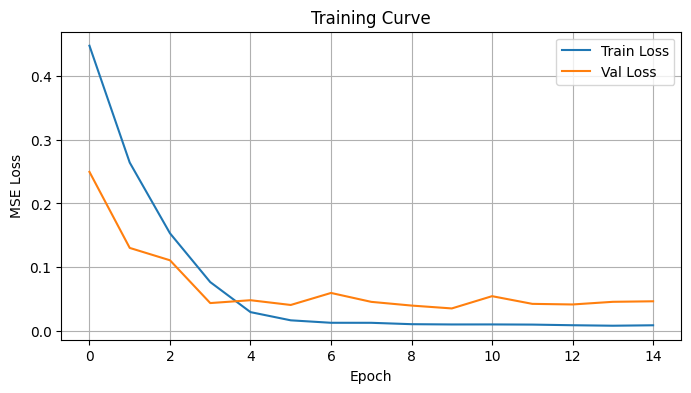

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# Define the model
model = Sequential()
model.add(LSTM(64, activation='relu', return_sequences=True, input_shape=(X.shape[1], X.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(32, activation='relu'))
model.add(Dense(n_future))  # Output a vector with n_future days

model.compile(optimizer='adam', loss='mse')

# Train the model
history = model.fit(
    X, y,
    epochs=30,
    batch_size=16,
    validation_split=0.2,
    callbacks=[EarlyStopping(patience=5, restore_best_weights=True)],
    verbose=1
)

# Plot training vs validation loss
plt.figure(figsize=(8, 4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Training Curve")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.grid(True)
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step


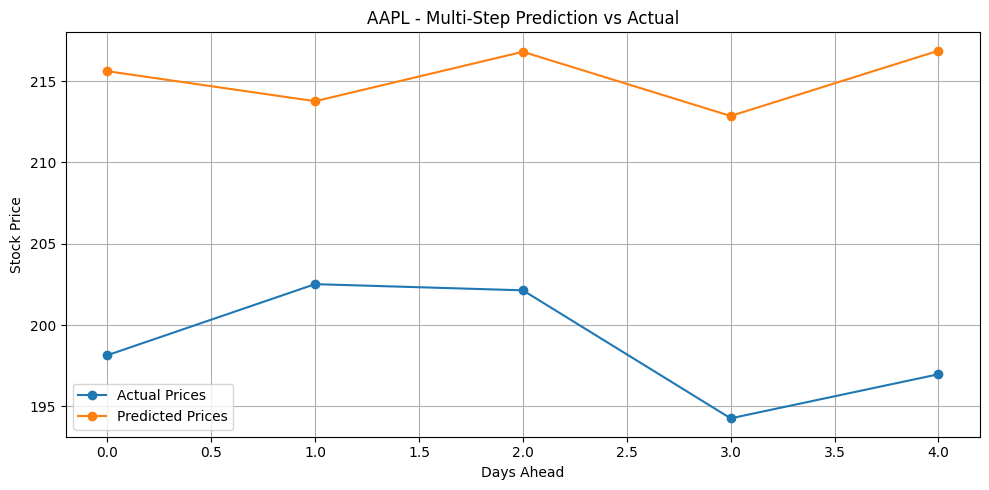

In [14]:
# Select the final sequence from the dataset for testing
test_input = scaled_data[-(n_input + n_future):-n_future]  # Last input window
actual_values = close_prices[-n_future:]  # Last actual 5 days

# Reshape and predict
input_seq = test_input.reshape(1, n_input, 1)
predicted_scaled = model.predict(input_seq)
predicted_values = scaler.inverse_transform(predicted_scaled)[0]

# Plot
plt.figure(figsize=(10, 5))
plt.plot(range(n_future), actual_values, label="Actual Prices", marker='o')
plt.plot(range(n_future), predicted_values, label="Predicted Prices", marker='o')
plt.title(f"{ticker} - Multi-Step Prediction vs Actual")
plt.xlabel("Days Ahead")
plt.ylabel("Stock Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
